> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Training a model

In [1]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

To keep things simple, we use one scene for training and one for validation. In a real workflow, we would normally use many more scenes.

In [2]:
train_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [3]:
val_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

In [4]:
import albumentations as A

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

In [5]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform)

len(train_ds)

2022-12-15 14:26:01:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif.
2022-12-15 14:26:01:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (2, 1024) is too non-square. This can slow down reading. Consider re-tiling using GDAL.
2022-12-15 14:26:01:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


400

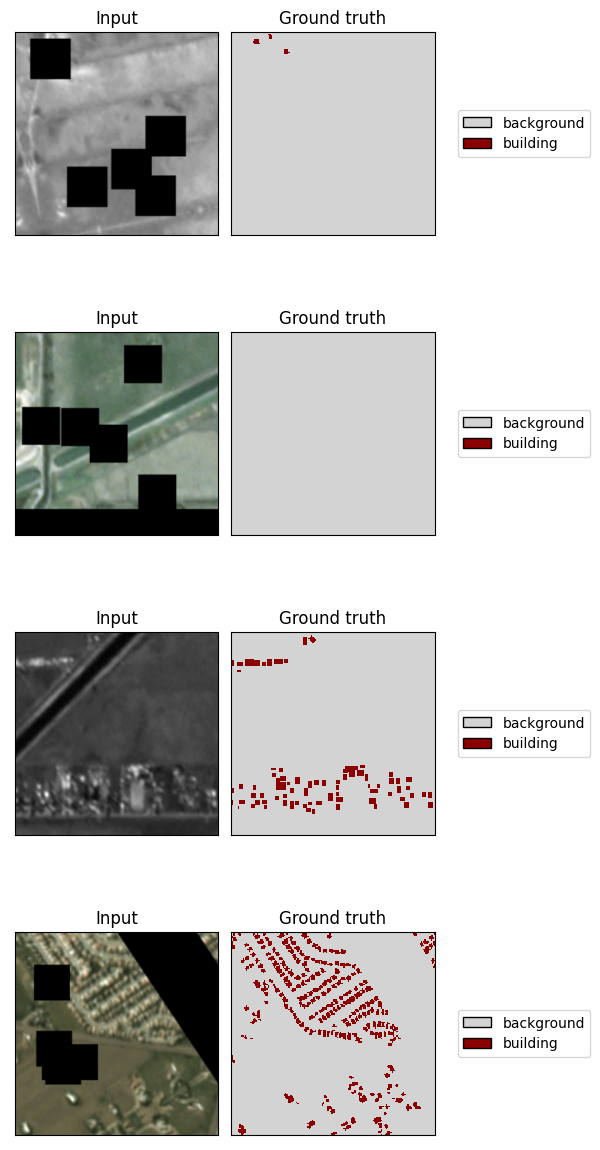

In [8]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

In [6]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=100,
    transform=A.Resize(256, 256))

len(val_ds)

2022-12-15 14:26:05:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif.
2022-12-15 14:26:05:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (2, 1024) is too non-square. This can slow down reading. Consider re-tiling using GDAL.
2022-12-15 14:26:05:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson.


100

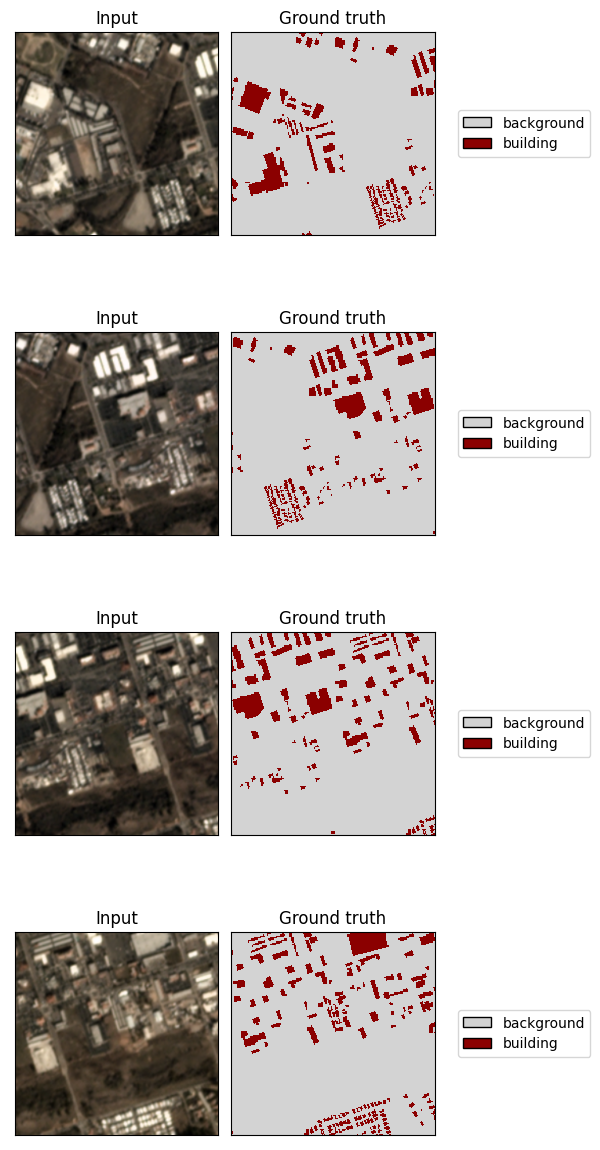

In [10]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

## Define model

Use a [light-weight panoptic FPN model](https://github.com/AdeelH/pytorch-fpn) with a ResNet-18 backbone.

In [7]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_0.3


## Configure the training

In [9]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0, # increase to use multi-processing
)

In [10]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)

In [11]:
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [12]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)

In [13]:
learner.log_data_stats()

2022-12-15 14:26:26:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2022-12-15 14:26:26:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items


## Run `Tensorboard` for monitoring

In [13]:
%load_ext tensorboard

This will start an instance of tensorboard and embed it in the output of the cell:

In [ ]:
%tensorboard --bind_all --logdir "./train-demo/tb-logs" --reload_interval 10 

![A screenshot of the Tensorboard dashboard.](../../img/tensorboard.png "A screenshot of the Tensorboard dashboard.")


In [14]:
learner.train(epochs=3)

2022-12-15 14:26:42:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:26:57:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9074727892875671,
 'avg_precision': 0.9226699471473694,
 'avg_recall': 0.8927680850028992,
 'background_f1': 0.9416702389717102,
 'background_precision': 0.9641342163085938,
 'background_recall': 0.9202292561531067,
 'building_f1': 0.3365422785282135,
 'building_precision': 0.2660379707813263,
 'building_recall': 0.45789051055908203,
 'epoch': 0,
 'train_loss': 0.06389201164245606,
 'train_time': '0:00:10.922799',
 'val_loss': 0.06789381802082062,
 'valid_time': '0:00:03.880362'}
2022-12-15 14:26:57:rastervision.pytorch_learner.learner: INFO - epoch: 1


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:27:12:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9250732064247131,
 'avg_precision': 0.916088879108429,
 'avg_recall': 0.9342355132102966,
 'background_f1': 0.9656270146369934,
 'background_precision': 0.9497168064117432,
 'background_recall': 0.9820793271064758,
 'building_f1': 0.2418244332075119,
 'building_precision': 0.3835538327693939,
 'building_recall': 0.17657652497291565,
 'epoch': 1,
 'train_loss': 0.032022590637207034,
 'train_time': '0:00:10.916714',
 'val_loss': 0.12407467514276505,
 'valid_time': '0:00:04.199710'}
2022-12-15 14:27:13:rastervision.pytorch_learner.learner: INFO - epoch: 2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:27:28:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.8449840545654297,
 'avg_precision': 0.9309152960777283,
 'avg_recall': 0.7735764980316162,
 'background_f1': 0.8657280802726746,
 'background_precision': 0.9788642525672913,
 'background_recall': 0.7760347723960876,
 'building_f1': 0.27820268273353577,
 'building_precision': 0.1715911626815796,
 'building_recall': 0.7346470952033997,
 'epoch': 2,
 'train_loss': 0.03501858711242676,
 'train_time': '0:00:11.307989',
 'val_loss': 0.05712978541851044,
 'valid_time': '0:00:04.134225'}


## Train some more

In [15]:
learner.train(epochs=3)

2022-12-15 14:27:28:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 3
2022-12-15 14:27:28:rastervision.pytorch_learner.learner: INFO - epoch: 3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:27:44:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.8460741639137268,
 'avg_precision': 0.9367697834968567,
 'avg_recall': 0.7713902592658997,
 'background_f1': 0.8635478019714355,
 'background_precision': 0.984494686126709,
 'background_recall': 0.7690666317939758,
 'building_f1': 0.29575374722480774,
 'building_precision': 0.18099400401115417,
 'building_recall': 0.8081868290901184,
 'epoch': 3,
 'train_loss': 0.03204505920410156,
 'train_time': '0:00:11.553398',
 'val_loss': 0.05406069755554199,
 'valid_time': '0:00:04.054214'}
2022-12-15 14:27:44:rastervision.pytorch_learner.learner: INFO - epoch: 4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:28:00:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.832942545413971,
 'avg_precision': 0.9333340525627136,
 'avg_recall': 0.7520503401756287,
 'background_f1': 0.8505723476409912,
 'background_precision': 0.9818631410598755,
 'background_recall': 0.7502516508102417,
 'building_f1': 0.272173136472702,
 'building_precision': 0.16482366621494293,
 'building_recall': 0.7805342674255371,
 'epoch': 4,
 'train_loss': 0.030616183280944825,
 'train_time': '0:00:11.438546',
 'val_loss': 0.058418720960617065,
 'valid_time': '0:00:04.163509'}
2022-12-15 14:28:00:rastervision.pytorch_learner.learner: INFO - epoch: 5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:28:16:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.8777509331703186,
 'avg_precision': 0.930891215801239,
 'avg_recall': 0.8303500413894653,
 'background_f1': 0.9030481576919556,
 'background_precision': 0.9763485193252563,
 'background_recall': 0.8399853110313416,
 'building_f1': 0.32184305787086487,
 'building_precision': 0.2110251784324646,
 'building_recall': 0.6777646541595459,
 'epoch': 5,
 'train_loss': 0.028649821281433105,
 'train_time': '0:00:11.639080',
 'val_loss': 0.053958915174007416,
 'valid_time': '0:00:04.503397'}


2022-10-21 14:00:43:rastervision.pytorch_learner.learner: INFO - Plotting predictions...


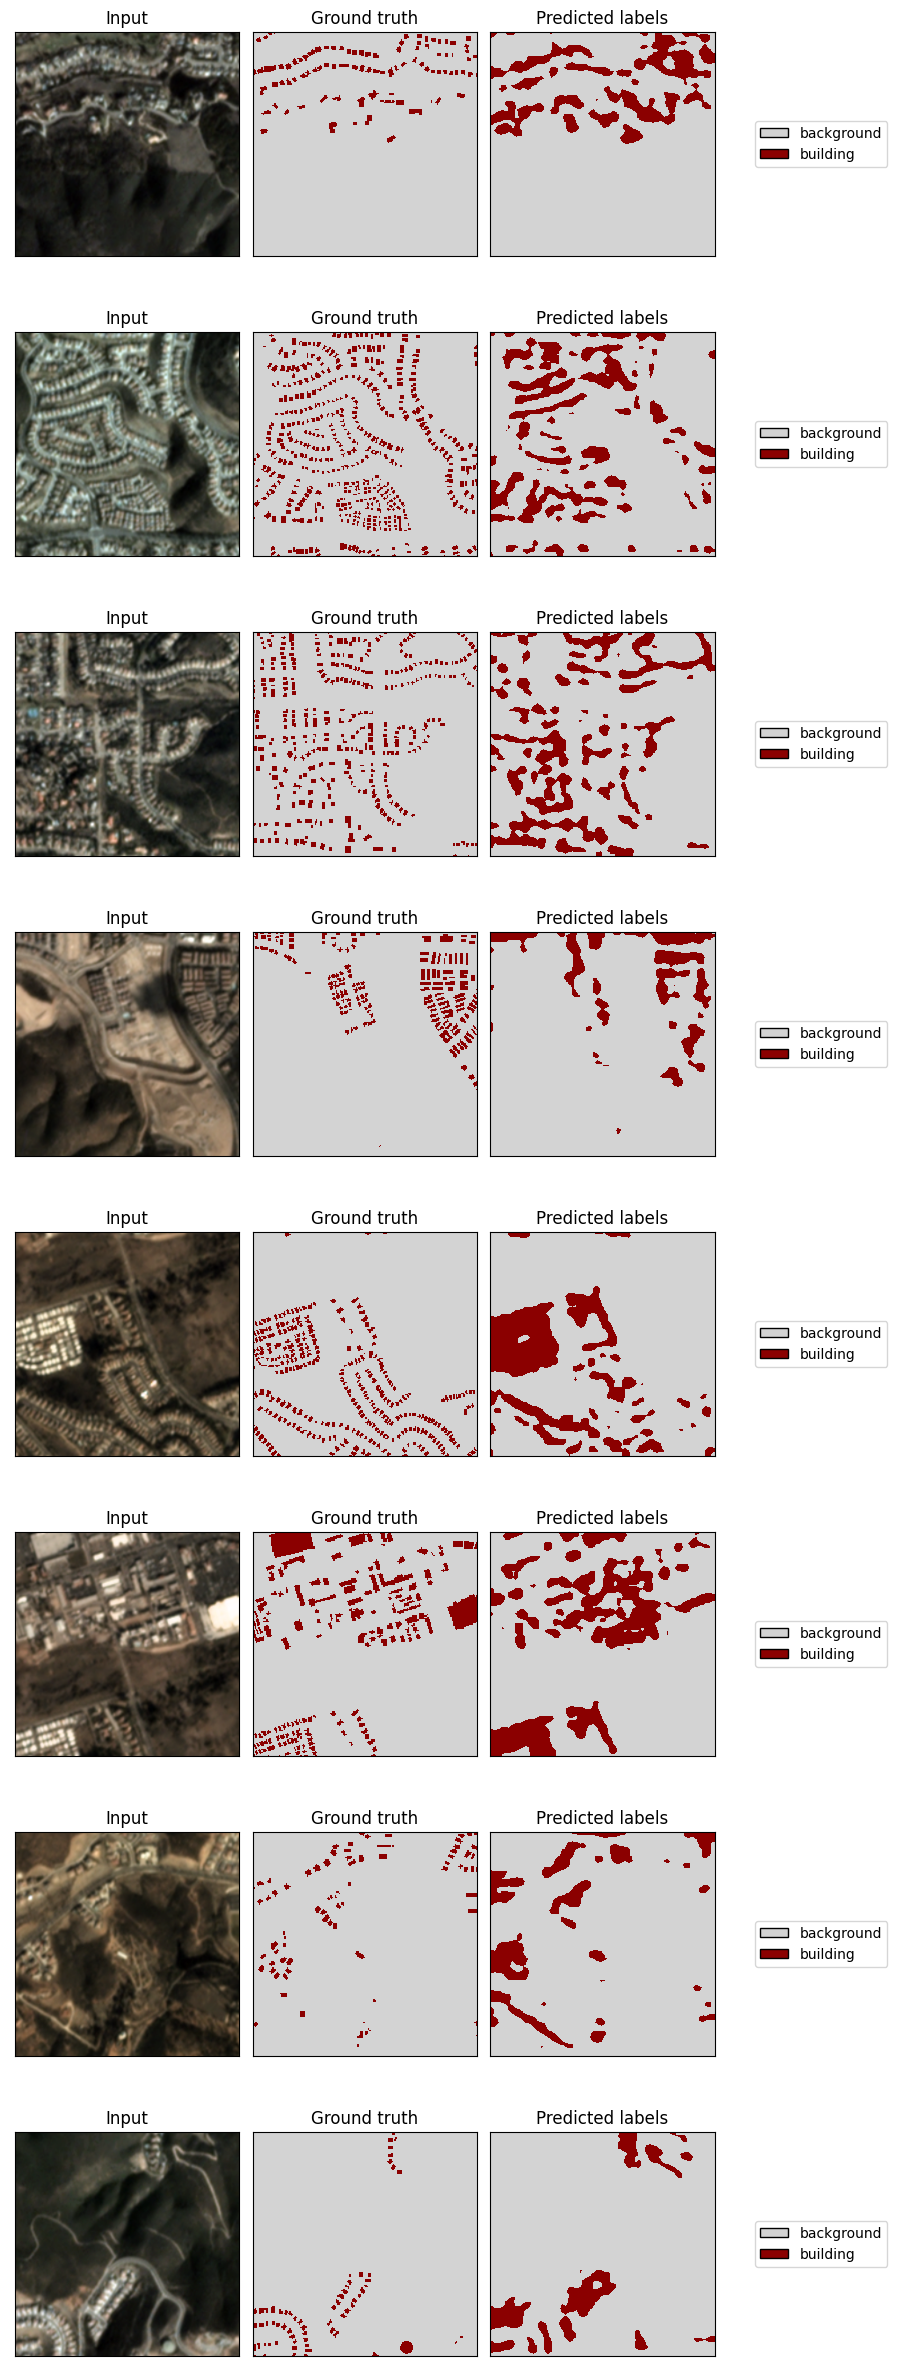

<Figure size 640x480 with 0 Axes>

In [19]:
learner.plot_predictions(split='valid', show=True)

Note the warning about `ModelConfig`. This is relevant when loading from from the bundle as we will see [below](#Using-model-bundles).

In [16]:
learner.save_model_bundle()

2022-12-15 14:28:17:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2022-12-15 14:28:17:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2022-12-15 14:28:18:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./train-demo/model-bundle.zip.


## Examine learner output

The trained model weights are saved at `./train-demo/last-model.pth` as well as inside the model-bundle.

In [20]:
!tree "./train-demo/"

./train-demo/
├── last-model.pth
├── learner-config.json
├── log.csv
├── model-bundle.zip
├── tb-logs
│   └── events.out.tfevents.1670411413.8a5ee9f3ced0.102.0
└── valid_preds.png

1 directory, 6 files


## Using model-bundles

We can use the model-bundle to re-construct our `Learner` and then use it to make predictions.

In [17]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='./train-demo/model-bundle.zip',
    output_dir='./train-demo/',
    model=model,
)

2022-12-15 14:28:21:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2022-12-15 14:28:21:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmp_9hxtbek/model-bundle
2022-12-15 14:28:21:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmp_9hxtbek/model-bundle/model.pth


For next steps, see the ["Prediction and Evaluation" tutorial](./pred_and_eval_ss.ipynb).

We can also re-construct the `Learner` in order to continue training, perhaps on a different dataset. To do this, we pass in `train_ds` and `val_ds` and set `training=True`

In [18]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='./train-demo/model-bundle.zip',
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2022-12-15 14:28:22:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2022-12-15 14:28:22:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpcx15mo9q/model-bundle
2022-12-15 14:28:22:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpcx15mo9q/model-bundle/model.pth
2022-12-15 14:28:22:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./train-demo/last-model.pth


Continue training:

In [19]:
learner.train(epochs=1)

2022-12-15 14:28:23:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 6
2022-12-15 14:28:23:rastervision.pytorch_learner.learner: INFO - epoch: 6


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 14:28:39:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.812635600566864,
 'avg_precision': 0.9350194334983826,
 'avg_recall': 0.7185811996459961,
 'background_f1': 0.8263904452323914,
 'background_precision': 0.9844221472740173,
 'background_recall': 0.7120786905288696,
 'building_f1': 0.2574964761734009,
 'building_precision': 0.15267422795295715,
 'building_recall': 0.8215558528900146,
 'epoch': 6,
 'train_loss': 0.04115571975708008,
 'train_time': '0:00:11.777954',
 'val_loss': 0.05978838726878166,
 'valid_time': '0:00:04.738656'}
